# Airbnb prices

Vamos fazer uma análise dos preços dos anúncios do airbnb da cidade Rio de Janeiro. Usaremos o xgboost como modelo predileto.

Dividimos este notebook nas seguintes seções:
* 1 - **Limpeza** -- limpamos os dados
* 2 - **Análise** -- aqui vemos a distribuição de preço e definimos nosso critério de avaliação (nosso benchmark)
* 3 - **Transformação** -- transformamos as features em tipos que o modelo consegue interpretar
* 4 - **Modelo** -- aplicamos o modelo e fazemos o hyperparameter tuning
* 5 - **Conclusão** -- um pequeno parágrafo para o que foi feito

In [1]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df2 = pd.read_csv('listings.csv')

In [3]:
df2.shape

(26615, 74)

In [4]:
pd.set_option('display.max_columns', 74)

In [5]:
df2.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\r\nI am a filmmaker and a tea...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,90,3.0,3.0,90.0,90.0,3.0,90.0,NaN,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","French girl ""lost in Brazilian translation"" si...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""Kitche

# 1 - Limpeza

In [6]:
df = df2.copy()

Há valores duplicados?

In [7]:
df.duplicated().value_counts()

False    26615
dtype: int64

Não. Então, primeiro, fazemos uma inspeção inicial em cada coluna:

In [8]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [9]:
df.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.661500e+04,26615,2.661500e+04,26615,26586,25160,14314,26615,2.661500e+04,26615,26591,26591,26508,12895,18599,18599,17074,26591,26591,26591,15344,26591.000000,26591.000000,26615,26591,26591,14314,26615,0.0,26615.000000,26615.000000,26615,26615,26615.000000,0.0,26543,24869.000000,26363.000000,26615,26615,26615.000000,2.661500e+04,26531.000000,26531.000000,2.653100e+04,2.653100e+04,26531.000000,2.653100e+04,0.0,26615,26615.000000,26615.000000,26615.000000,26615.000000,26615,26615.000000,26615.000000,26615.000000,16657,16657,16118.000000,16104.000000,16107.000000,16106.000000,16110.000000,16106.000000,16108.000000,0.0,26615,26615.000000,26615.000000,26615.000000,26615.000000,16657.000000
unique,NaN,26615,NaN,4,25807,24458,13121,26129,NaN,17324,5145,3392,963,6975,4,79,94,2,17220,17220,156,NaN,NaN,358,2,2,271,151,NaN,NaN,NaN,87,4,NaN,NaN,52,NaN,NaN,23932,1694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,2610,1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/31690188,NaN,2021-02-24,Apartamento em Copacabana,Super comfortable apartment in Barra da Tijuca...,"The neighborhood is located in the South Zone,...",https://a0.muscache.com/pictures/ac50dd2b-7158...,NaN,https://www.airbnb.com/users/show/371026651,Daniel,2020-10-07,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Meu nome é Daniel, eu sou francês e moro no Br...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/64b61...,https://a0.muscache.com/im/pictures/user/64b61...,Copacabana,NaN,NaN,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,NaN,NaN,Entire apartment,Entire home/apt,NaN,NaN,1 bath,NaN,NaN,"[""Long term stays allowed""]",$200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,2021-02-24,NaN,NaN,NaN,2020-02-26,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,13192,34,17,18,11,NaN,295,312,298,13176,198,8792,10986,6471,22038,295,295,5426,NaN,NaN,3968,26502,16766,5530,7712,NaN,NaN,NaN,15354,19285,NaN,NaN,10648,NaN,NaN,302,811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25830,NaN,NaN,NaN,NaN,13192,NaN,NaN,NaN,262,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17466,NaN,NaN,NaN,NaN,NaN
mean,2.526448e+07,NaN,2.021022e+13,NaN,NaN,NaN,NaN,NaN,1.006657e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.367568,9.367568,NaN,NaN,NaN,NaN,NaN,NaN,-22.965837,-43.248533,NaN,NaN,4.161112,NaN,NaN,1.707909,2.548230,NaN,NaN,4.725268,3.819109e+04,4.660510,5.032038,3.842962e+04,3.843929e+04,4.788828,3.843440e+04,NaN,NaN,19.245200,41.221379,64.233440,219.438174,NaN,12.146308,2.341725,0.296487,NaN,NaN,94.571349,9.636612,9.392376,9.799888,9.758535,9.759717,9.296374,NaN,

De imediato já podemos fazer o seguinte:
* Excluir (pois são colunas vázias): `neighbourhood_group_cleansed`, `bathrooms`, `license`, `calendar_updated`;
* Transformar em número: `bathrooms_text` e `price`;
* Transformar as colunas booleanas com `t` e `f` em colunas com `1` e `0`.

### Remoção de colunas excedentes

Além das colunas acima, que estão vazias, há outras que (assumiremos) não contribuem para o preço, viz., `id`, `listing_url`, `host_id`, `scrape_id`, `last_scraped`, `name`, `description`, `neighborhood_overview`, `picture_url`, `host_url`, `host_location`, `host_name`, `host_about`, `host_thumbnail_url`, `host_picture_url`, `host_response_time`, `host_response_rate`, `host_acceptance_rate`, `host_neighbourhood`, `neighbourhood` (`neighbourhood` é uma versão suja de `neighbourhood_cleansed`, então ficaremos com `neighbourhood_cleansed`) e `calendar_last_scraped`.

Ainda além destas há algumas colunas de uma mesma categoria (por exemplo, `minimum_nights`, `minimum_minimum_nights`, `host_listings_count`,`host_total_listings_count` etc.

Algumas destas podem ser supérfluas. Para saber se elas de fato são vamos verificar a correlação entre elas -- entre cada uma dentro de uma categoria.

Achamos quatro cateogiras diferentes: `nights`, `listing`, `availability` e `reviews`. Definimos cada uma abaixo.

In [10]:
nights = df[['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']]

listing = df[['host_listings_count','host_total_listings_count','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']]

availability = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']]

reviews = df[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

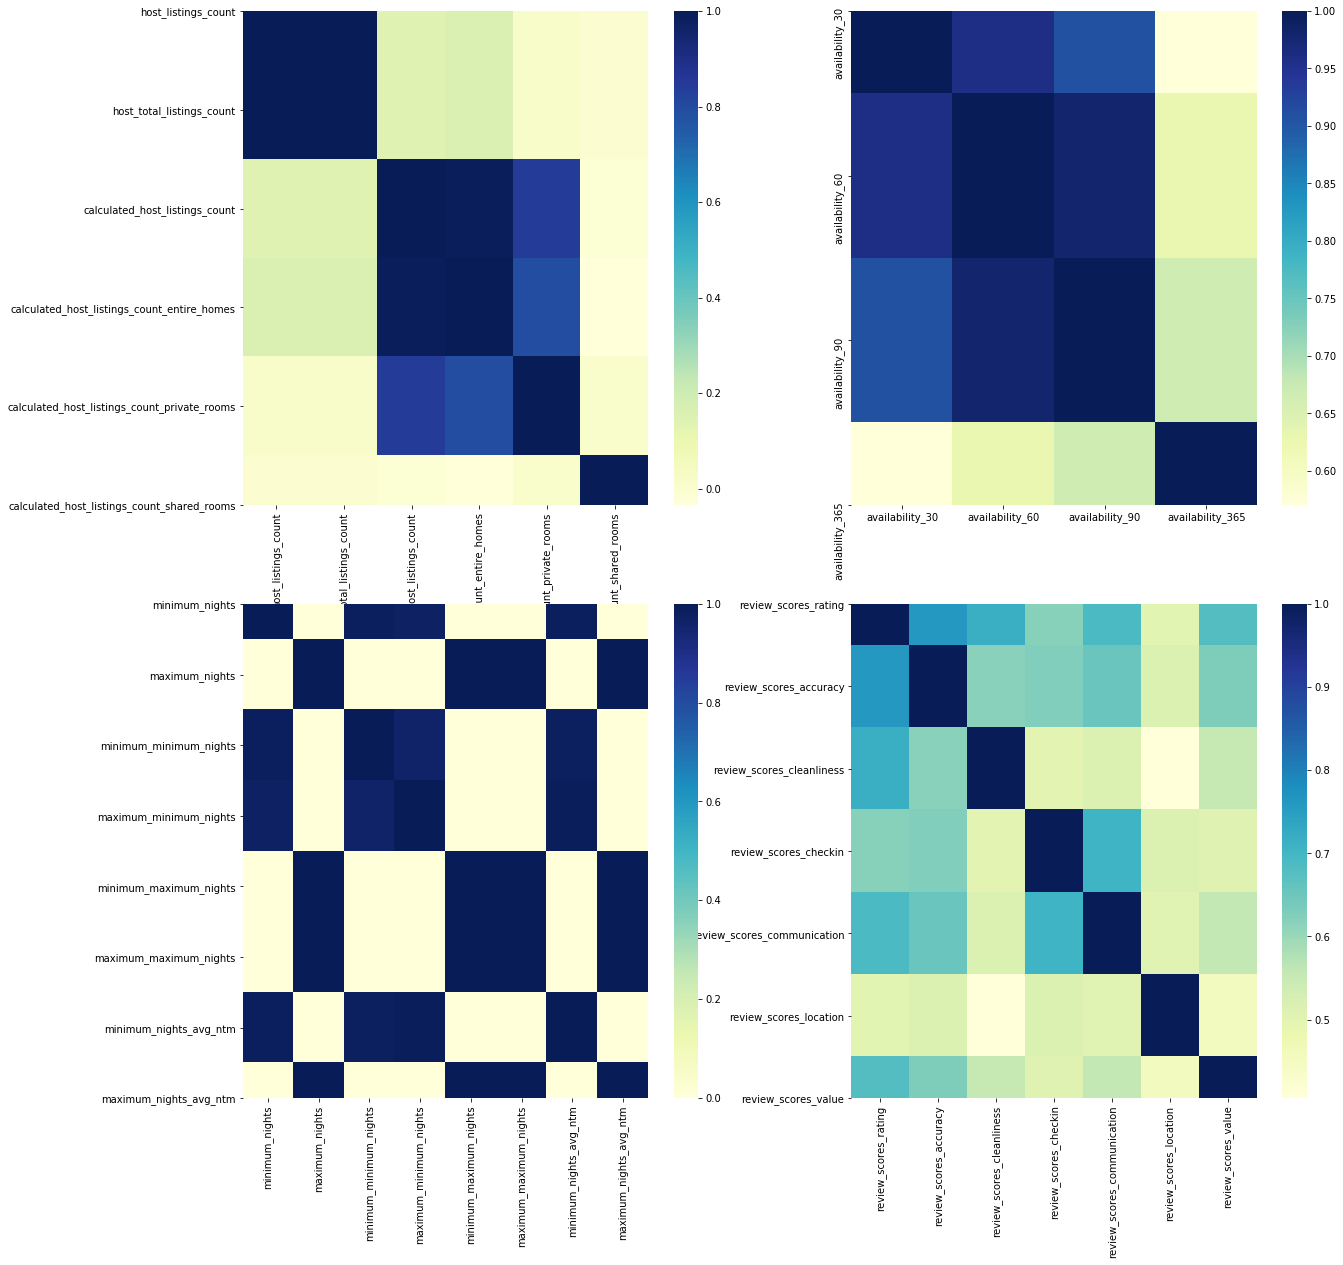

In [11]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.heatmap(listing.corr(),  cmap="YlGnBu", ax=ax1)
sns.heatmap(availability.corr(),  cmap="YlGnBu", ax=ax2)
sns.heatmap(nights.corr(),  cmap="YlGnBu", ax=ax3)
sns.heatmap(reviews.corr(),  cmap="YlGnBu", ax=ax4)

Desses quatro gráficos vemos que podemos eliminar colunas de três deles: 
* na categoria `nights` deixamos somente `minimum_nights` e `maximum_nights`;
* de `listings` eliminamos `host_total_listings_count`, `calculated_host_listings_count_entire_homes` e `calculated_host_listings_count_private_rooms`;
* e de `availability` excluímos `availability_60` e `availability_90`.

De `review` não excluímos nada por enquanto.

A coluna `last_scraped` poderia conter informações sobre mudança de preço ao longo do tempo (e.g., inflação, oferta-demanda, etc.). Mas, conforme a célula abaixo, as informações foram coletadas em mais ou menos o mesmo tempo. Então vamos dispensar com essas colunas também.

In [12]:
df['last_scraped'].unique()

array(['2021-02-23', '2021-02-24', '2021-02-25', '2021-02-22'],
      dtype=object)

Por fim, inspecionando os valores únicos de `property_type` e `room_type` vemos que essas duas colunas contém, em essencia, a mesma informação -- porém, `property_type` é a informação mais granular. Essa informação mais granular -- onde varias propriedades só tem uma instância de um `property_type` -- pode gerar muito barulho na nossa análise.

Por este motivo vamos descartar a coluna `property_type` em favor da `room_type`.

In [13]:
types = ['property_type', 'room_type']

for t in types:
    print(t, ':')
    print(df[t].unique())
    print('-'*100)

property_type :
['Entire condominium' 'Entire apartment' 'Entire loft' 'Entire house'
 'Private room in apartment' 'Private room in bed and breakfast'
 'Entire townhouse' 'Private room in house' 'Private room in guest suite'
 'Shared room in hostel' 'Shared room in apartment' 'Earth house'
 'Private room in condominium' 'Entire guest suite'
 'Entire serviced apartment' 'Entire guesthouse' 'Shared room in house'
 'Private room in loft' 'Room in hostel' 'Private room in chalet'
 'Entire bungalow' 'Room in boutique hotel' 'Private room in treehouse'
 'Private room in guesthouse' 'Private room' 'Private room in earth house'
 'Entire hostel' 'Private room in serviced apartment' 'Entire place'
 'Private room in hostel' 'Private room in townhouse'
 'Private room in tiny house' 'Entire chalet' 'Entire cottage'
 'Entire villa' 'Treehouse' 'Room in serviced apartment' 'Entire cabin'
 'Private room in villa' 'Shared room' 'Room in aparthotel'
 'Shared room in tiny house' 'Private room in nature l

In [14]:
df['property_type'].value_counts(ascending=True).head(20)

Private room in farm stay        1
Private room in tent             1
Treehouse                        1
Shared room in bungalow          1
Entire hostel                    1
Private room in cabin            1
Yurt                             1
Shared room in nature lodge      1
Hut                              1
Entire vacation home             1
Shared room in townhouse         1
Private room in boat             1
Camper/RV                        1
Shared room in castle            1
Private room in treehouse        1
Shared room in cottage           1
Entire home/apt                  1
Shared room in farm stay         1
Shared room in boutique hotel    2
Houseboat                        2
Name: property_type, dtype: int64

In [15]:
droppers = ['id', 'scrape_id', 'listing_url', 'host_id', 'last_scraped', 'name', 'description', 'listing_url', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_60', 'availability_90', 'property_type', 'calendar_updated', 'calendar_last_scraped', 'license', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms']

In [16]:
df.drop(columns=droppers, inplace=True)

In [17]:
len(df.columns)

37

### Transformação

Para transformar em número as colunas acima vamos inspecionar cada elemento único delas para saber as comonalidades:

In [18]:
trans_num = ['bathrooms_text', 'price']

for cols in trans_num:
    print(cols, ':')
    print(df[cols].unique())
    print('-'*100)

bathrooms_text :
['1 bath' '1.5 baths' '7 baths' '3.5 baths' '3 baths' '2.5 baths'
 '2 baths' '1 private bath' '4 baths' '5 shared baths' nan '1 shared bath'
 '4.5 shared baths' '2 shared baths' '1.5 shared baths' '0 shared baths'
 '5 baths' '0 baths' '6 baths' 'Shared half-bath' '10 baths'
 '2.5 shared baths' '4.5 baths' '8 baths' '4 shared baths'
 '3 shared baths' '6.5 baths' '5.5 baths' '7.5 baths' 'Half-bath'
 '3.5 shared baths' '7 shared baths' '11.5 baths' '15 baths'
 '20 shared baths' '20 baths' '6.5 shared baths' '12.5 baths' '11 baths'
 '12 baths' '15.5 baths' '8.5 baths' '6 shared baths' 'Private half-bath'
 '10.5 baths' '13 baths' '9 baths' '8.5 shared baths' '9.5 baths'
 '18 baths' '9 shared baths' '8 shared baths' '5.5 shared baths']
----------------------------------------------------------------------------------------------------
price :
['$221.00' '$307.00' '$160.00' ... '$1,716.00' '$1,232.00' '$865.00']
----------------------------------------------------------------

Apesar da coluna `price` ter muitos valores únicos para listar conseguimos ver que o padrão é `$`+numero ou `$`+numero+virgula+numero.

Já `bathrooms_text` teremos que criar uma nova coluna que contém a informação se o banheiro é dividido ou não.

In [19]:
pattern_price = r"([0-9]+?,?[0-9]+)"
price = df['price'].str.contains(pattern_price)
price.value_counts()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


True    26615
Name: price, dtype: int64

`price.value_counts()` retornou `True` para todos os valores: isso significa que o nosso `pattern_price` captura todos os preços da coluna `price`.

In [20]:
df['price'] = df['price'].str.extract(pattern_price)
df['price'] = df['price'].str.replace(',','').astype(float)

#### Banheiros

Primeiro, vemos que há valores nulos em `bathroom_text`, mas que eles são muito poucos comparados com a quantidade de todos os dados (segundo abaixo, os valores nulos desta coluna representam apenas `0.2%` do total).

Então vamos simplesmente eliminar as linhas com valores nulos.

In [21]:
df['bathrooms_text'].isnull().sum()/df.shape[0]

0.0027052414052226186

In [22]:
df.dropna(subset=['bathrooms_text'], inplace=True)

In [23]:
df.reset_index(drop=True, inplace=True)

Antes de criar uma coluna com valores numericos de banheiros vamos criar uma coluna com a informação se o banheiro é particular ou dividido:

In [24]:
pattern_shared = r"shared"
shared = df['bathrooms_text'].str.contains(pattern_shared, flags=re.I)

In [25]:
shared.unique()

array([False,  True])

In [26]:
df['shared_bathroom'] = shared.replace({True: 1, False: 0})

In [27]:
df['shared_bathroom'].unique()

array([0, 1])

Finalmente vamos criar uma coluna chamada `bathroom` que contém a quantidade de banheiros. Abaixo assumimos que um `half-bath` é `0.5` e extraímos a parte numerica de `bathroom_text`.

In [28]:
df['bathrooms_text'] = df['bathrooms_text'].replace({'Private half-bath': '0.5', 'Shared half-bath':'0.5', 'Half-bath':'0.5'})

In [29]:
pattern_baths = r"([0-9]+\.?[0-9]?)"
baths = df['bathrooms_text'].str.extract(pattern_baths)

In [30]:
df['bathrooms'] = baths.astype(float)

In [31]:
df.drop(columns=['bathrooms_text'], inplace=True)

### Colunas booleanas

As seguintes colunas são booleanas: `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `has_availability`, `instant_bookable`.

E vamos transformalas em colunas com `0` e `1`.

In [32]:
bools = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']

In [33]:
df[bools] = df[bools].replace({'t':1, 'f': 0})

In [34]:
df[bools]

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,1.0,1.0,1.0,1,1
1,0.0,1.0,1.0,1,0
2,0.0,1.0,0.0,1,0
3,1.0,1.0,1.0,1,0
4,1.0,1.0,1.0,1,0
...,...,...,...,...,...
26538,0.0,1.0,0.0,1,0
26539,0.0,1.0,1.0,1,1
26540,0.0,1.0,1.0,1,1
26541,1.0,1.0,1.0,1,0


## Lidando com os `NaN`s

In [35]:
df.isnull().sum()

host_since                                        23
host_is_superhost                                 23
host_listings_count                               23
host_verifications                                 0
host_has_profile_pic                              23
host_identity_verified                            23
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
room_type                                          0
accommodates                                       0
bedrooms                                        1735
beds                                             224
amenities                                          0
price                                              0
minimum_nights                                     0
maximum_nights                                     0
has_availability                                   0
availability_30                               

A coluna mais preocupante aqui é `bedrooms`, já que, suponho, ela é um fator determinante para o preço. As demais podem ser trabalhadas: `reviews` provavelmente estão vázias por não terem recebido reviews; os `23` hosts que não sabemos quem são pouquissimos -- poderíamos simplesmente descartar essas linhas; e `beds` também é relativamente baixo o número de nulos (somente `0.8%` -- vide infra).

In [36]:
df['beds'].isnull().sum()/len(df)

0.008439136495497872

Adotaremos a seguinte estratégia: Primeiro, uma suposição razoável é a de que locais que estão sem o campo `beds` mas que são do tipo `Shared room` só tem uma cama. Então preencheremos esses casos com `beds = 1`.

Esse caso só equivalem a `10` linhas com `NaN` em `beds` (abaixo). Iremos descartar os `23` hosts desconhecidos e as `214` linhas restantes sem informações sobre as camas -- se não houver intersecção entre esses dois essa eliminação não chega nem a `1%` dos nossos dados. Então é melhor eliminar do que criar mais um *Ansatz*.

Em `reviews` faremos substituições razoáveis, assumindo que essas linhas estão vázias por falta de review.

Por fim, em `bedrooms`, usaremos o algoritimo dos K-Vizinhos (K-Neighboors) mais próximos para fazer substituições razoáveis.

#### `beds` e `host_*`

In [37]:
df[df['beds'].isnull()]['room_type'].value_counts()

Private room       125
Entire home/apt     89
Shared room         10
Name: room_type, dtype: int64

In [38]:
condition = df['room_type'] == 'Shared room'
df.loc[condition,'beds'] = df.loc[condition,'beds'].fillna(1)

In [39]:
df.dropna(subset=['beds', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [40]:
df.isnull().sum()

host_since                                         0
host_is_superhost                                  0
host_listings_count                                0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
room_type                                          0
accommodates                                       0
bedrooms                                        1711
beds                                               0
amenities                                          0
price                                              0
minimum_nights                                     0
maximum_nights                                     0
has_availability                                   0
availability_30                               

#### Reviews

Para confirmar se de fato muitas dos valores nulos de `reviews` são porque não há ainda reviews dessas locações vamos fazer um gráfico mapeando os valores nulos.

Abaixo definimos uma função que fasz isso.

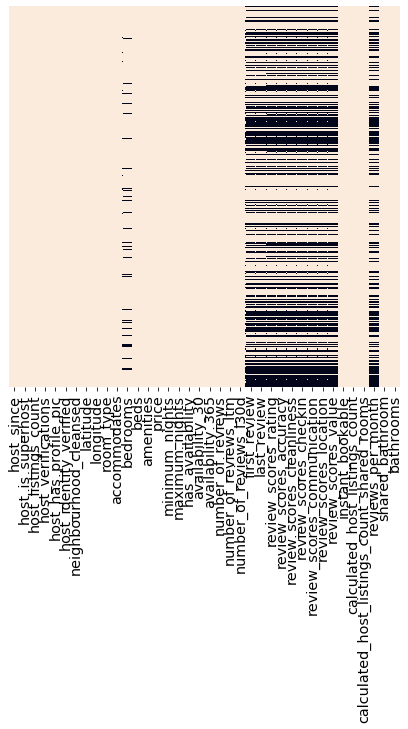

In [41]:
def plot_null_matrix(df, figsize=(7,7)):
    plt.figure(figsize=figsize)
    df_null = df.isnull()
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()
    
plot_null_matrix(df)

De fato, muitos valores que são nulos em, digamos, `first_review` são nulos nas demais colunas que dizem respeito a reviews.

Para confirmar isso podemos ver que de fato os unicos valores das colunas de reviews quando `first_review = NaN` são valores nulos:

In [42]:
reviews = ['review_scores_rating', 'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

for r in reviews:
    print(df[df['first_review'].isnull()][r].unique())

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]


Para preencher essas linhas vamos usar a seguinte heuristica: para `first_review` e `last_review` vamos usar uma data futura e `first_review = last_review`.

Para as demais colunas vamos substituir os valores nulos pela média de cada coluna.

Ainda vamos testar a importância de cada coluna para verificar se o que fazemos faz sentido ou se só vai gerar barulho.

In [43]:
reviews = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

condition_review = df['first_review'].isnull()

for r in reviews:
    df.loc[condition_review, r] = df.loc[condition_review, r].fillna(df[r].mean())

In [44]:
df['first_review'].fillna('2021-03-14', inplace=True)
df['last_review'].fillna('2021-03-14', inplace=True)

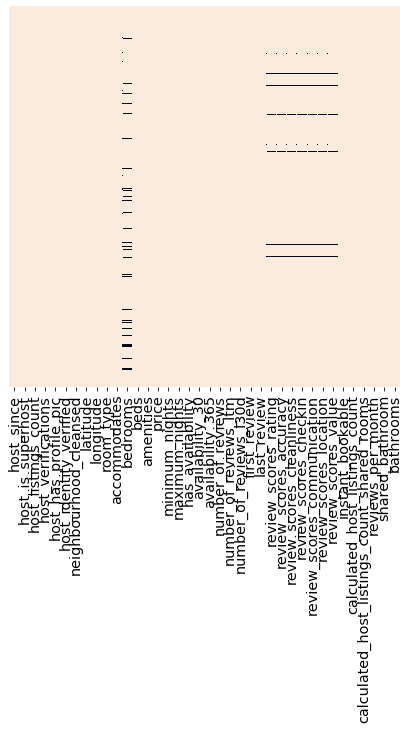

In [45]:
plot_null_matrix(df)

Ainda sobraram algumas linhas com valores nulos. Essas vamos excluir:

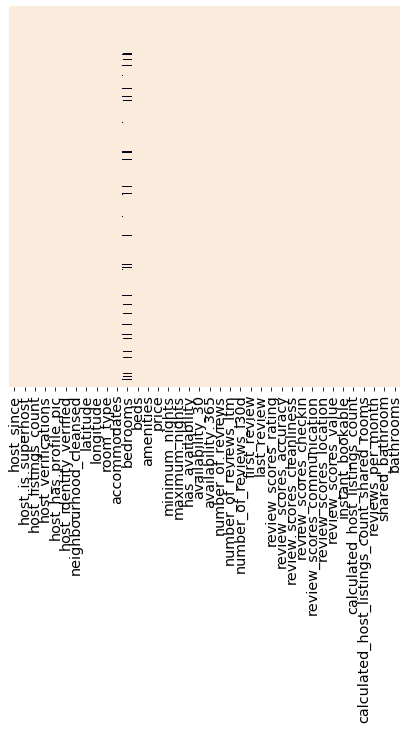

In [46]:
df.dropna(subset=reviews, inplace=True)
df.reset_index(drop=True, inplace=True)
plot_null_matrix(df)

#### Quartos

Vejamos quais propriedades mais se correlacionam com `bedrooms`. Iremos escolher as que mais fazem sentido e usaremos o algoritimo K-Nearest Neighbors, que dado as features que escolhermos abaixo e o target (`bedrooms`) ele vê quais são os vizinhos de features mais próximos e sabendo a propriedade target (através do treinamento) ele infere qual o valor do nosso target (através do fit).

Usaremos o root mean squared error como métrica e o standard deviation como benchmark.

In [47]:
df.corr()['bedrooms'].sort_values(ascending=False)

bedrooms                                       1.000000
bathrooms                                      0.755283
accommodates                                   0.727320
beds                                           0.631257
price                                          0.437137
calculated_host_listings_count                 0.072762
availability_30                                0.057016
availability_365                               0.056142
has_availability                               0.038706
host_listings_count                            0.036626
minimum_nights                                 0.029521
host_identity_verified                         0.026099
maximum_nights                                -0.004348
review_scores_rating                          -0.006565
review_scores_checkin                         -0.006923
review_scores_location                        -0.014369
host_is_superhost                             -0.014764
host_has_profile_pic                          -0

In [48]:
df_nona = df.copy().dropna()
X_train, X_test, y_train, y_test = train_test_split(df_nona[['bathrooms', 'accommodates']] , df_nona['bedrooms'], random_state = 0)

In [49]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
predictions_test = knn.predict(X_test)
predictions_train = knn.predict(X_train)

In [50]:
print('RMSE test:', np.sqrt(mean_squared_error(y_test, predictions_test)))
print('RMSE train:', np.sqrt(mean_squared_error(y_train, predictions_train)))
print('-'*100)
print('Standard Deviation para o y_test:', np.std(y_test))

RMSE test: 0.6715640988546305
RMSE train: 0.5659917666873884
----------------------------------------------------------------------------------------------------
Standard Deviation para o y_test: 1.112151379607268


Parece que não há tanto overfitting e o RMSE do conjunto de teste é bem menor que o nosso benchmark, o desvio padrão. Como uma heuristica para preencher valores nulos esses resultados são suficientes.

Vamos usar este modelo para prever os valores nulos de bedrooms e substituí-los no dataframe:

In [51]:
X_nan = df[df['bedrooms'].isnull()][['bathrooms', 'accommodates']]
predictions_nan = knn.predict(X_nan)

In [52]:
values_nan = pd.Series(predictions_nan, index=df[df['bedrooms'].isnull()].index)
df['bedrooms'].fillna(values_nan, inplace=True)

E finalmente trabalhamos todos os valores nulos:

In [53]:
df.isnull().sum().sum()

0

# 2 - Analise

Abaixo vemos que o preço é **muito** right-skewed. Como queremos usar o xgboost para prever o preço temos que tratar esse dado antes -- gradient boosting é bem sensível a outliers, e pela experiência que fizemos mudar a função objetivo (por exemplo, uma que aproxima o MAE, como a função de Huber) não nos ajuda em nada.

Para resolver isso transformamos o preço em log(preço), e conseguimos uma distribuição menos skewed.

### Critério de avaliação:

Aqui definimos o critério pelo qual o nosso modelo sera julgado: supomos que quando alguém procura um lugar no airbnb, além do preço, uma das primeiras coisas que a pessoa julga é a localização.

Mas como há bairros com poucos anuncios, o que fazemos é calcular a mean absolute deviation (MAD) para cada bairro e depois tiramos a média de todos. Isso gera uma medida com menos variabilidade e captura informação tanto das regiões onde o desvio é baixo quanto as que tem desvio alto.

Escolhemos usar o MAD/MAE pela skewedness dos dados -- e comparar MAE com STD seria muito fácil: o STD seria muito maior que o MAE e isso poderia causar a impressão de um bom modelo, enquanto que na verdade ele não é bom.

skew: 5.033755791144686


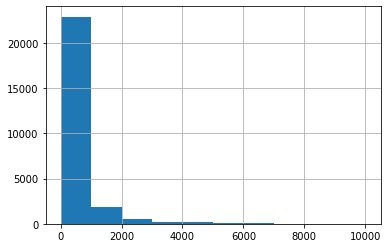

In [54]:
df['price'].hist()
print('skew:', df['price'].skew())

In [55]:
df['target'] = np.log(df['price'])

skew: 0.4805627937345857


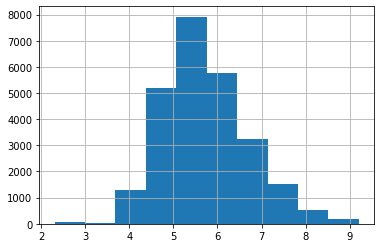

In [56]:
df['target'].hist()
print('skew:', df['target'].skew())

Definição do benchmark:

In [57]:
madl = []

for n in df['neighbourhood_cleansed'].unique():
    madl.append(df[df['neighbourhood_cleansed'] == n]['price'].mad())

benchmark = pd.Series(madl).mean()

print('Benchmark:', benchmark)

Benchmark: 348.322133682524


# 3 - Transformações

Agora vamos transformar as features para que elas sejam tipos compatíveis com o modelo.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25754 entries, 0 to 25753
Data columns (total 39 columns):
host_since                                     25754 non-null object
host_is_superhost                              25754 non-null float64
host_listings_count                            25754 non-null float64
host_verifications                             25754 non-null object
host_has_profile_pic                           25754 non-null float64
host_identity_verified                         25754 non-null float64
neighbourhood_cleansed                         25754 non-null object
latitude                                       25754 non-null float64
longitude                                      25754 non-null float64
room_type                                      25754 non-null object
accommodates                                   25754 non-null int64
bedrooms                                       25754 non-null float64
beds                                           25754 non-

### Amenities

A coluna amenities está estremamente desorganizada: ela não é sequer uma coluna de listas, mas uma coluna de strings que parecem listas (célula abaixo). Então o primeiro passo é transformar essa string em listas contendo strings, e para isso definimos a função `clean_list_on_df` abaixo.

Como há muitos valores distintos em cada uma das listas vamos adotar a seguinte estratégia: depois de transformar as strings em listas vamos criar variáveis binárias para cada elemento de cada lista -- resultando em um dataframe (`amd` abaixo). Escolheremos, desse dataframe, as colunas cuja soma seja maior que 200 (um número arbitrário que escolhemos) -- ou seja, só escolheremos as amenidades que mais de 200 locações possuem.

In [59]:
type(df['amenities'][0])

str

In [60]:
def amenities_clean(series):
    s = []
    for element in series:
        res = element.replace('[', '').replace(']','')
        res = res.replace('"', '')
        res = res.split(',')
        res = [x.strip() for x in res]
        s.append(res)
    return pd.Series(s)

In [61]:
amenities = amenities_clean(df['amenities'])

In [62]:
amenities

0        [Air conditioning, Essentials, Luggage dropoff...
1        [Extra pillows and blankets, Air conditioning,...
2        [Elevator, Dedicated workspace, Kitchen, Bed l...
3        [Air conditioning, Essentials, Luggage dropoff...
4        [Extra pillows and blankets, Air conditioning,...
                               ...                        
25749    [Kitchen, Washer, Hot water, Air conditioning,...
25750    [Dedicated workspace, Kitchen, Air conditionin...
25751    [Wine glasses, Extra pillows and blankets, BBQ...
25752    [Extra pillows and blankets, Essentials, Lugga...
25753    [Air conditioning, Essentials, Paid parking of...
Length: 25754, dtype: object

In [63]:
mlb = MultiLabelBinarizer()

amd = pd.DataFrame(mlb.fit_transform(amenities),columns=mlb.classes_, index=amenities.index)

In [64]:
amd.columns

Index(['', '02 Bocas electric stove', '02 bocas c/forno gas stove',
       '04 bocas c/forno gas stove', '1 space', '100 spaces', '14\ TV',
       '17\ TV with standard cable', '2 Burner Hot plate electric stove',
       '2 bocas electric stove',
       ...
       'table', 'tramontina gas stove',
       'uma porta com geladeira e freezer integrados refrigerator',
       'v\u00e1riadas body soap', 'v\u00e1rias body soap',
       'variadas body soap', 'variadas conditioner', 'variadas shampoo',
       'walk-in closet', 'wardrobe'],
      dtype='object', length=835)

Vemos, de cara, que há uma coluna sem informação sobre amenidade nenhuma chamada `''`. Vamos retira-la:

In [65]:
amd.drop(columns=[''], inplace=True)

Escolhemos colunas com mais de 200 na soma:

In [66]:
major = amd.columns[amd.sum() > 200]

In [67]:
amd[major].sum().sort_values()

Baby safety gates               207
Clothing storage: wardrobe      220
Hot water kettle                244
Keypad                          251
Lake access                     288
                              ...  
TV                            21499
Essentials                    21878
Long term stays allowed       22175
Wifi                          22972
Kitchen                       23317
Length: 87, dtype: int64

In [68]:
df.drop(columns=['amenities'], inplace=True)

In [69]:
df = pd.concat([df, amd[major]], axis=1)

### `host_verifications`

`host_verifications` tem o mesmo problema de amenities acima, mas é ligeiramente diferente. Vamos aplicar a mesma solução, então -- ligeiramente modificada.

In [70]:
type(df['host_verifications'][0])

str

In [71]:
def verifications_clean(series):
    s = []
    for element in series:
        res = element.replace('[', '').replace(']','')
        res = res.replace('"', '')
        res = res.split(',')
        res = [x.strip() for x in res]
        res = [x.replace("'",'') for x in res]
        s.append(res)
    return pd.Series(s)

In [72]:
verifications = verifications_clean(df['host_verifications'])

In [73]:
verifications

0        [email, phone, reviews, jumio, offline_governm...
1        [email, phone, facebook, reviews, jumio, gover...
2        [phone, reviews, jumio, offline_government_id,...
3        [email, phone, facebook, reviews, manual_offli...
4            [email, phone, reviews, jumio, government_id]
                               ...                        
25749                                       [email, phone]
25750    [email, phone, facebook, reviews, jumio, offli...
25751    [email, phone, manual_offline, jumio, offline_...
25752    [email, phone, reviews, jumio, selfie, governm...
25753    [email, phone, reviews, jumio, selfie, governm...
Length: 25754, dtype: object

In [74]:
vd = pd.DataFrame(mlb.fit_transform(verifications),columns=mlb.classes_, index=verifications.index)

In [75]:
vd.columns

Index(['', 'email', 'facebook', 'google', 'government_id', 'identity_manual',
       'jumio', 'kba', 'manual_offline', 'manual_online',
       'offline_government_id', 'phone', 'reviews', 'selfie', 'sent_id',
       'work_email'],
      dtype='object')

In [76]:
vd.drop(columns=[''], inplace=True)

In [77]:
vd.sum()

email                    23147
facebook                  5996
google                    1427
government_id            16465
identity_manual           7131
jumio                    13954
kba                        120
manual_offline             551
manual_online              127
offline_government_id    11216
phone                    25366
reviews                  13001
selfie                    7772
sent_id                     18
work_email                2459
dtype: int64

In [78]:
df.drop(columns=['host_verifications'], inplace=True)

In [79]:
df = pd.concat([df, vd], axis=1)

Agora nos resta apenas transformar as datas (`host_since`, `first_review` e `last_review`) em números e criar os dummies de `neighbourhood_cleansed` e `room_type`.

Este último passo podemos fazer em uma linha:

In [80]:
df = pd.get_dummies(df, columns=['neighbourhood_cleansed', 'room_type'])

### Datas

Para converter as datas em números definimos a função `convert_date` abaixo, que transforma a string legível de uma data em um número correspondente.

In [81]:
def convert_date(val):
        return datetime.fromisoformat(val).timestamp()

In [82]:
df['host_since'] = df['host_since'].apply(convert_date)
df['first_review'] = df['first_review'].apply(convert_date)
df['last_review'] = df['last_review'].apply(convert_date)

In [83]:
df

,host_since,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_shared_rooms,reviews_per_month,shared_bathroom,bathrooms,target,Air conditioning,BBQ grill,...,neighbourhood_cleansed_Santa Cruz,neighbourhood_cleansed_Santa Teresa,neighbourhood_cleansed_Santo Cristo,neighbourhood_cleansed_Santíssimo,neighbourhood_cleansed_Saúde,neighbourhood_cleansed_Senador Camará,neighbourhood_cleansed_Senador Vasconcelos,neighbourhood_cleansed_Sepetiba,neighbourhood_cleansed_São Conrado,neighbourhood_cleansed_São Cristóvão,neighbourhood_cleansed_São Francisco Xavier,neighbourhood_cleansed_Tanque,neighbourhood_cleansed_Taquara,neighbourhood_cleansed_Tauá,neighbourhood_cleansed_Tijuca,neighbourhood_cleansed_Todos os Santos,neighbourhood_cleansed_Tomás Coelho,neighbourhood_cleansed_Urca,neighbourhood_cleansed_Vargem Grande,neighbourhood_cleansed_Vargem Pequena,neighbourhood_cleansed_Vasco da Gama,neighbourhood_cleansed_Vaz Lobo,neighbourhood_cleansed_Vicente de Carvalho,neighbourhood_cleansed_Vidigal,neighbourhood_cleansed_Vigário Geral,neighbourhood_cleansed_Vila Isabel,neighbourhood_cleansed_Vila Kosmos,neighbourhood_cleansed_Vila Militar,neighbourhood_cleansed_Vila Valqueire,neighbourhood_cleansed_Vila da Penha,neighbourhood_cleansed_Vista Alegre,neighbourhood_cleansed_Zumbi,neighbourhood_cleansed_Água Santa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1.262916e+09,1.0,2.0,1.0,1.0,-22.96592,-43.17896,5,2.0,2.0,221.0,5,180,1,0,304,260,12,2,1.279163e+09,1.612753e+09,94.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1,1,0,2.010000,0,1.0,5.398163,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.269572e+09,0.0,0.0,1.0,1.0,-22.98570,-43.20193,2,1.0,1.0,307.0,3,90,1,0,10,85,0,0,1.285470e+09,1.518574e+09,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,0,1,0,0.670000,0,1.0,5.726848,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1.349233e+09,0.0,11.0,1.0,0.0,-22.97712,-43.19045,2,1.0,2.0,160.0,7,60,1,0,328,238,0,0,1.275880e+09,1.581736e+09,94.000000,9.000000,9.000000,9.000000,10.000000,10.000000,9.000000,0,11,0,1.820000,0,1.0,5.075174,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.277608e+09,1.0,1.0,1.0,1.0,-22.98816,-43.19359,2,1.0,1.0,273.0,2,89,1,0,207,181,2,0,1.382407e+09,1.584241e+09,94.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0,1,0,2.020000,0,1.5,5.609472,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.277608e+09,1.0,1.0,1.0,1.0,-22.98127,-43.19046,2,1.0,1.0,135.0,3,15,1,4,101,353,25,4,1.286075e+09,1.612926e+09,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0,1,0,2.790000,0,1.0,4.905275,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25749,1.613704e+09,0.0,4.0,1.0,0.0,-23.01452,-43.46005,1,1.0,1.0,94.0,1,365,1,30,180,0,0,0,1.615691e+09,1.615691e+09,94.576088,9.637828,9.393934,9.800961,9.759765,9.760517,9.297304,0,4,0,0.629504,0,0.5,4.543295,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25750,1.490152e+09,0.0,0.0,1.0,1

# 4 - Modelo

Como dissemos vamos usar o xgboost para prever os preços. Primeiro, vamos selecionar as colunas (features) mais relevantes usando o RFECV do sklearn que testa um modelo com várias combinações recursivas das features (com cross validation) e seleciona a melhor combinação.

Como esse processo demora muito, fizemos ele uma vez e salvamos o resultado em `optimized_columns_airbnb.data`.

In [84]:
x = df.drop(['price', 'target'], axis=1)
y = df['target']

In [ ]:
xgb_f = xgboost.XGBRegressor(seed=1)

selector = RFECV(xgb_f, scoring='neg_mean_squared_error', cv=3)
selector.fit(x, y)

optimized_columns = x.columns[selector.support_]

with open('optimized_columns_airbnb.data', 'wb') as filehandle:
    pickle.dump(optimized_columns, filehandle)

Abaixo lemos os dados que geramos (a melhor combinação das colunas):

In [85]:
with open('optimized_columns_airbnb.data', 'rb') as filehandle:
    optimized_columns = pickle.load(filehandle)

In [86]:
x = x[optimized_columns]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 1)

In [88]:
xgb_reg = xgb.XGBRegressor(seed=1)

xgb_reg.fit(X_train, y_train,
             verbose=0,
             early_stopping_rounds=50,
             eval_set=[(X_test, y_test)])

y_xgb = xgb_reg.predict(X_test)

In [89]:
def resultados(model, y_test=y_test, y_train=y_train, X_test=X_test, X_train=X_train):
    y_te = model.predict(X_test)
    y_tr = model.predict(X_train)
    print('train MAE:', mean_absolute_error(np.exp(y_train), np.exp(y_tr)))
    print('test MAE:', mean_absolute_error(np.exp(y_test), np.exp(y_te)))

In [90]:
resultados(xgb_reg)

train MAE: 193.59063377000186
test MAE: 261.6818089259302


## Hyperparameter tuning

Para fazer o hyperparameter tuning recorremos ao AWS, pois conseguimos fazer todo o processo em algumas horas, enquanto que fazer no nosso computador local levaria muito mais tempo.

Abaixo colocamos o código que executamos no AWS's sagemaker, e retornamos a este notebook em seguida.

In [ ]:
############################################################ AWS

import sagemaker

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

prefix = 'sagemaker/cognitivo'
region = boto3.Session().region_name
role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
sm_client = boto3.Session().client('sagemaker')

import pandas as pd
import numpy as np

import io
import os
import sys
import time
import json
import pickle
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

x = df.drop(['price' ,'target'], axis=1)
y = df['target']

with open('optimized_columns_airbnb.data', 'rb') as filehandle:
    optimized_columns = pickle.load(filehandle)
    
x = x[optimized_columns]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 1)
train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)
train.to_csv('train_airbnb.csv', header=False, index=False)
test.to_csv('validation_airbnb.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_airbnb.csv')).upload_file('train_airbnb.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_airbnb.csv')).upload_file('validation_airbnb.csv')

s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

container = sagemaker.image_uris.retrieve('xgboost', region, version='latest')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)


xgb.set_hyperparameters(objective='reg:linear', seed=1, num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

tuner = HyperparameterTuner(
    xgb,
    objective_metric_name = 'validation:rmse',
    objective_type ='Minimize',
    hyperparameter_ranges = hyperparameter_ranges,
    max_jobs=150,
    max_parallel_jobs=4,
    strategy='Bayesian'
)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName = 'xgboost-210314-0429')

print(tuning_job_result['BestTrainingJob']['TunedHyperParameters'])

# output:

# {'alpha': '28.857787373812947',
#  'colsample_bylevel': '0.22882537971539896',
#  'colsample_bytree': '0.806376381605978',
#  'eta': '0.11854485758885966',
#  'gamma': '0.06954625711253386',
#  'lambda': '97.35832725489799',
#  'max_delta_step': '0',
#  'max_depth': '7',
#  'min_child_weight': '7.559488939030019',
#  'num_round': '3883',
#  'subsample': '0.7231527477948695'}

############################################################ Fim AWS

Usando esses parâmetros:

In [91]:
xgb_reg = xgb.XGBRegressor(reg_alpha=28.857787373812947,
                               colsample_bylevel=0.22882537971539896,
                               colsample_bytree=0.806376381605978,
                               learning_rate=0.11854485758885966,
                               min_split_loss=0.06954625711253386,
                               reg_lambda=97.35832725489799,
                               max_delta_step=0,
                               max_depth=7,
                               min_child_weight=7.559488939030019,
                               n_estimators=3883,
                               subsample=0.7231527477948695,
                               seed=1)

xgb_reg.fit(X_train, y_train,
             verbose=0,
             early_stopping_rounds=50,
             eval_set=[(X_test, y_test)])

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.22882537971539896, colsample_bynode=1,
             colsample_bytree=0.806376381605978, gamma=0.0695462599, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.11854485758885966, max_delta_step=0, max_depth=7,
             min_child_weight=7.559488939030019,
             min_split_loss=0.06954625711253386, missing=nan,
             monotone_constraints='()', n_estimators=3883, n_jobs=4,
             num_parallel_tree=1, random_state=1, reg_alpha=28.857787373812947,
             reg_lambda=97.35832725489799, scale_pos_weight=1, seed=1,
             subsample=0.7231527477948695, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [92]:
resultados(xgb_reg)

train MAE: 225.89017673801519
test MAE: 257.5705800140139


# 5 - Conclusão

Com este modelo conseguimos bater nosso benchmark (ca. 349), e com o tuning dos parâmetros conseguimos ainda reduzir consideravelmente a diferença entre o train MAE e o test MAE -- reduzindo o overfitting. Isso significa que este modelo é mais realista do que um modelo com a métrica de avaliação menor mas cuja diferença entre train e test é muito grande.